In [1]:
# Parameters
animal = "87-21"
col_names = ["time", "g1", "g2", "g3", "g4", "du1", "du2"]
chan_to_keep = ["time", "g1", "g2", "g3", "g4"]
new_sample_freq = 200
original_sample_freq = 2000
filter_type = "bandpass"
lo_cutoff = 0.05
hi_cutoff = 0.7
use_dropped_packet_removal = True
use_artifact_removal = True
pre_post_pts = 10
fill_frontend = True


# Load modules

In [2]:
# load modules
from rich import print
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from directory_structure import Tree
import sys, os
import os.path as path
import glob
import re
import pickle

modules = path.abspath(path.join(os.getcwd(), "helpers"))
print(modules)
sys.path.insert(0, modules)

from import_files import *
from preprocessing import *
from plotting import *

%matplotlib inline

/home/github_repos/PITT_NN_paper/1_preprocessing/helpers

# Load data, rename columns, save/load to pickles to increase speed (and remove channels)

In [3]:
# get list of files and pickles
####################################

file_lst = glob.glob("Data/" + animal + "/*.txt")
print(file_lst)

pickle_lst = glob.glob("pickles/" + animal + "*.pckl")
print(pickle_lst)

# make df names
####################################

df_name_lst = []
for x in file_lst:
    if 'eed' in x:
        df_name_lst.append('df_feed')
    if 'ase' in x:
        df_name_lst.append('df_base')

# load pickles or make pickles
####################################

if len(file_lst) == len(pickle_lst):
    print("import pickles")
    for x, y in zip(pickle_lst, df_name_lst):
        print(y)
        df_x = Import.open_pickle(x)
        exec(y + " = df_x")
        print()
else:
    print("import CSVs and make pickles")
    for x, y in zip(file_lst, df_name_lst):
        print(y)
        df_x = Import.csv_import_to_pandas(file_path=x, df_name=y, print_df=False)
        df_x.columns = col_names
        # drop channel
        df_x = df_x[chan_to_keep]
        print(df_x)
        # store pickle
        # create directory if it does not exist
        file_path = 'pickles/'
        if not os.path.exists(file_path):
            os.mkdir(file_path)
        Import.store_pickle(obj=df_x, file_path='pickles/' + animal + '_' + y +'.pckl')
        exec(y + " = df_x")
        print()

['Data/87-21/87-21_Feeding_9-1-21.txt', 'Data/87-21/87-21_Baseline_8-31-21.txt']

['pickles/87-21_df_feed.pckl', 'pickles/87-21_df_base.pckl']

import pickles

df_feed

time           g1            g2            g3           g4
0           0.0000 -7344.183105 -32884.093750  23536.769531 -5202.113281
1           0.0005 -7420.024902 -32882.191406  23218.414063 -5197.157715
2           0.0010 -7472.203613 -32885.531250  22958.935547 -5191.057617
3           0.0015 -7524.652344 -32889.800781  22759.451172 -5187.517578
4           0.0020 -7576.687500 -32881.273438  22624.220703 -5186.636719
...            ...          ...           ...           ...          ...
7201342  3600.6710 -9914.779297 -41558.691406  24823.748047 -2769.485596
7201343  3600.6715 -9913.999023 -41558.371094  24823.878906 -2768.846191
7201344  3600.6720 -9915.066406 -41559.593750  24823.412109 -2768.158691
7201345  3600.6725 -9916.204102 -41560.464844  24824.044922 -2768.418213
7201346  3600.6730 -9915.726563 -41559.093750  24824.912109 -2769.236328

[7201347 rows x 5 columns]

df_base

time           g1            g2            g3            g4
0           0.0000  1772.523804 -22563.126953   6929.405273 -20938.562500
1           0.0005  1769.157837 -22564.384766   6928.943848 -20937.400391
2           0.0010  1768.478638 -22564.341797   6929.016113 -20937.607422
3           0.0015  1770.642090 -22562.873047   6930.394531 -20938.154297
4           0.0020  1771.232056 -22560.636719   6930.969238 -20937.320313
...            ...          ...           ...           ...           ...
7202103  3601.0515  5483.481445 -43469.289063  19354.173828  -6428.459961
7202104  3601.0520  5480.376465 -43470.644531  19354.205078  -6425.617676
7202105  3601.0525  5481.129883 -43474.082031  19353.025391  -6422.601074
7202106  3601.0530  5483.773926 -43478.566406  19350.896484  -6421.295898
7202107  3601.0535  5485.191406 -43480.777344  19350.572266  -6420.447266

[7202108 rows x 5 columns]

## Determine percentage missing values

In [4]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Downsample after applying anti-aliasing filter

In [5]:
factor = int(original_sample_freq / new_sample_freq)
print(factor)

for x in df_name_lst:

    df1 = locals()[x]

    # get df with time values
    df_x = df1.iloc[::factor, :].time
    df_x.reset_index(drop=True, inplace=True)
    df_x = pd.DataFrame(df_x)

    for y in chan_to_keep[1:]:    
        arr = Preprocessing.downsample_with_anti_aliasing(arr=df1[y], factor=factor, ftype='iir')
        df_x[y] = arr.tolist()

    exec(x + " = df_x")
    print(df_x)

10

Original length = 7201347
New length = 720135
Original length = 7201347


New length = 720135
Original length = 7201347
New length = 720135
Original length = 7201347


New length = 720135


time           g1            g2            g3           g4
0          0.000 -7263.029739 -32508.507476  23331.771001 -5141.779872
1          0.005 -7593.281132 -32427.498700  19137.264037 -5135.110815
2          0.010 -7490.807543 -32325.109866  17960.999516 -5195.520638
3          0.015 -7471.645185 -32296.222552  23908.393939 -5221.507739
4          0.020 -7424.385187 -32273.432624  22271.928290 -5234.562898
...          ...          ...           ...           ...          ...
720130  3600.650 -9802.859068 -41079.294926  24536.539231 -2738.773636
720131  3600.655 -9803.241398 -41081.493790  24536.946707 -2738.184812
720132  3600.660 -9802.989234 -41082.153374  24538.023792 -2737.230640
720133  3600.665 -9801.604147 -41081.872385  24538.908257 -2737.934272
720134  3600.670 -9802.039126 -41082.691876  24539.926410 -2737.707689

[720135 rows x 5 columns]

Original length = 7202108
New length = 720211
Original length = 7202108


New length = 720211
Original length = 7202108
New length = 720211
Original length = 7202108


New length = 720211


time           g1            g2            g3            g4
0          0.000  1752.268774 -22305.085653   6850.337997 -20698.850478
1          0.005  1750.458830 -22300.835613   6847.170325 -20695.103977
2          0.010  1749.709495 -22303.160824   6837.076737 -20692.889745
3          0.015  1749.282187 -22304.984425   6828.449028 -20691.742962
4          0.020  1750.368256 -22302.996318   6816.385975 -20689.851251
...          ...          ...           ...           ...           ...
720206  3601.030  5444.199423 -42926.057240  19201.682011  -6383.279582
720207  3601.035  5449.649222 -42922.813419  19169.529432  -6380.186018
720208  3601.040  5438.301429 -42902.147805  19150.968978  -6368.284618
720209  3601.045  5432.767614 -42924.656466  19144.313571  -6375.704364
720210  3601.050  5426.601322 -42968.667747  19133.209181  -6363.427072

[720211 rows x 5 columns]

## Determine percentage missing values

In [6]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Remove dropped packets (errors in the hardware recording)

In [7]:
if use_dropped_packet_removal:
    
    df_packet_drop = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:

            df_x[y], removed_pct = Preprocessing.remove_dropped_packets_zerofill(arr=df_x[y], thres=100000)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
            
        exec(x + ' = df_x')
 
    df_packet_drop['cond'] = cond_lst
    df_packet_drop['chan'] = chan_lst
    df_packet_drop['removed_pct'] = removed_pct_lst
    
    print(df_packet_drop)

cond chan  removed_pct
0  df_feed   g1         2.58
1  df_feed   g2         6.35
2  df_feed   g3         3.94
3  df_feed   g4         0.29
4  df_base   g1         2.77
5  df_base   g2         0.72
6  df_base   g3         0.17
7  df_base   g4         0.06

## Determine percentage missing values

In [8]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[2.58104, 6.34534, 3.9437, 0.29008]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[2.76627, 0.72048, 0.1687, 0.05693]

#####################

# Plot raw signals

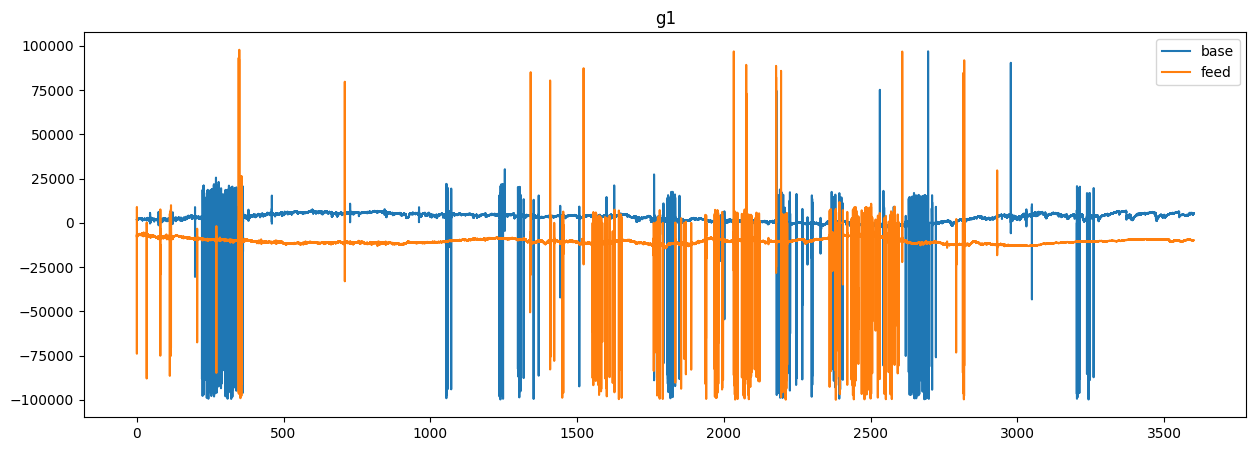

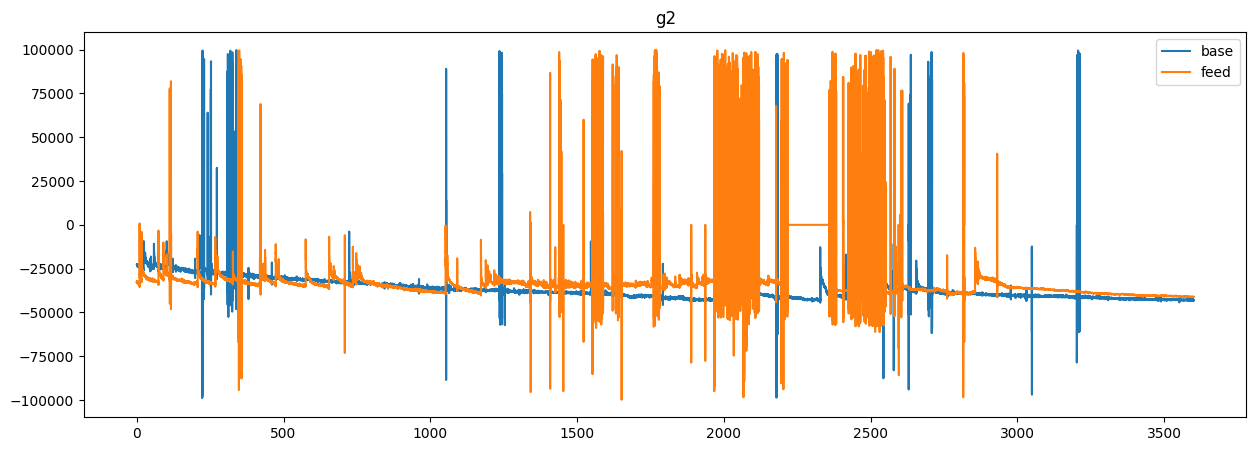

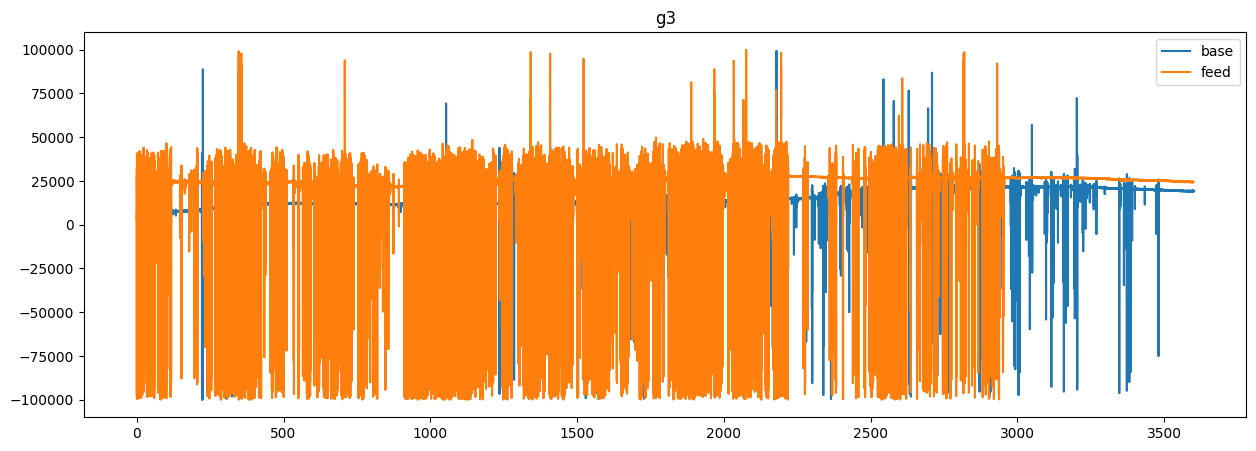

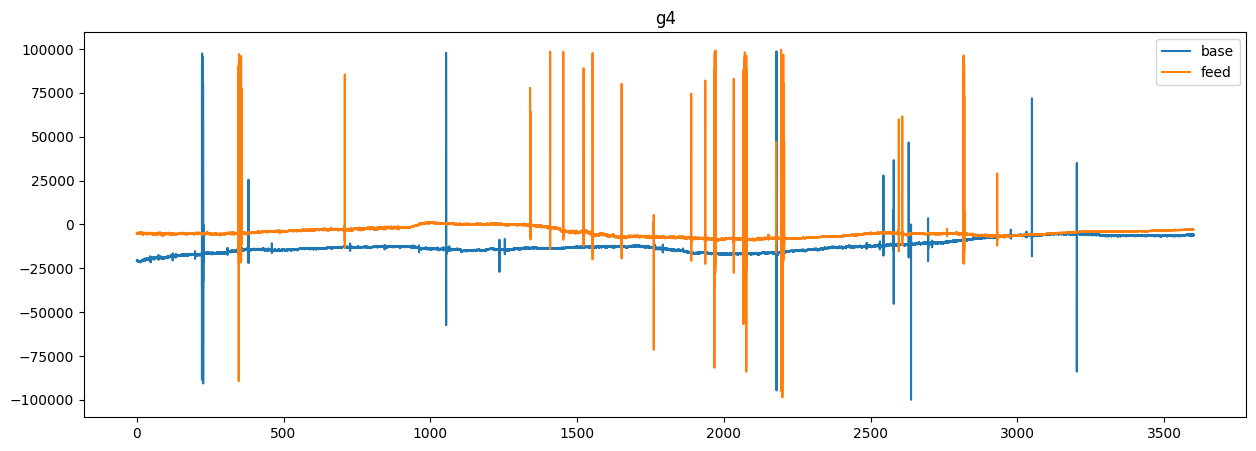

In [9]:
for x in chan_to_keep[1:]:
    plt.figure(figsize=(15,5))
    plt.title(x)
    plt.plot(df_base['time'], df_base[x], label='base')
    plt.plot(df_feed['time'], df_feed[x], label='feed')
    plt.legend(loc='upper right')

# Apply filters

## If band pass

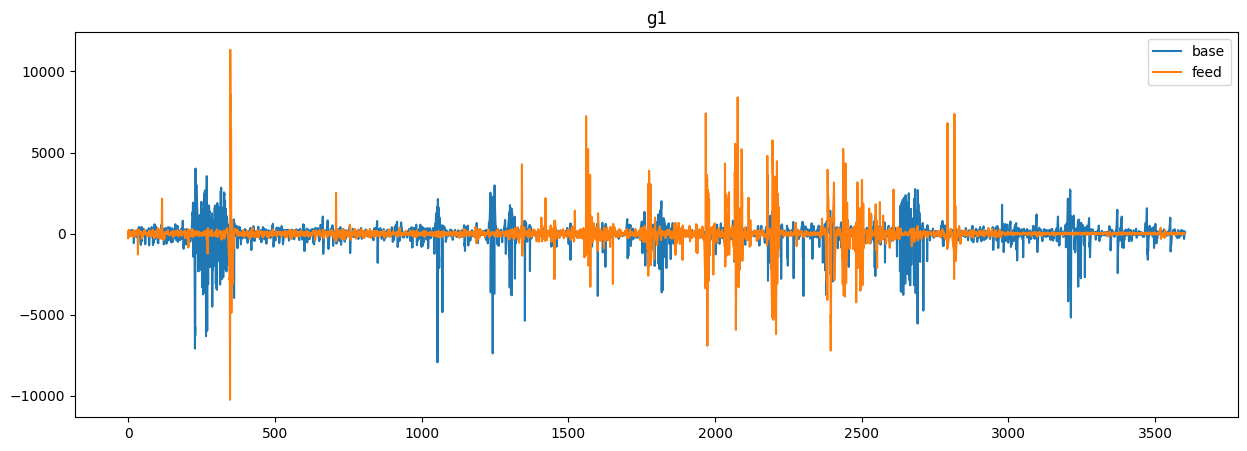

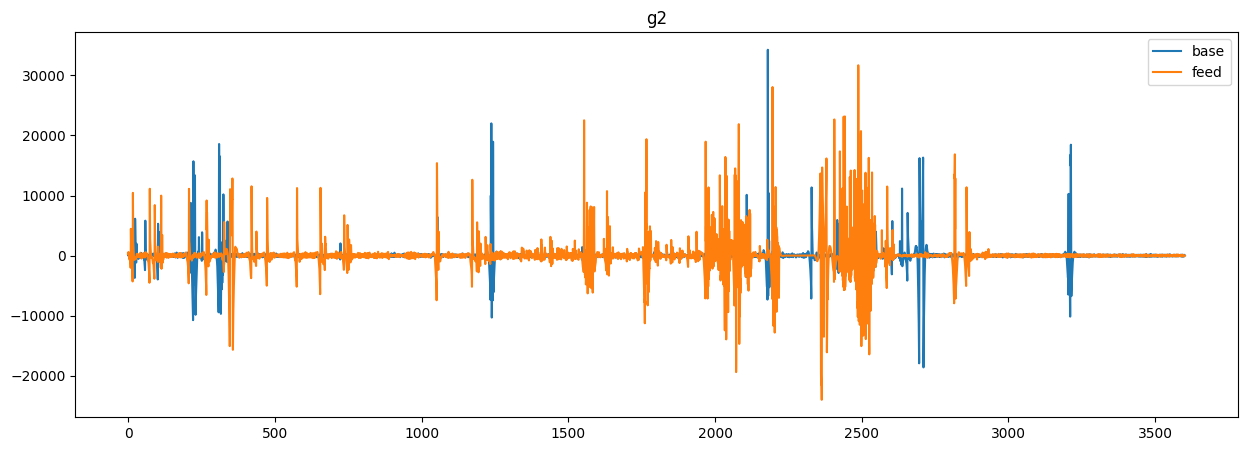

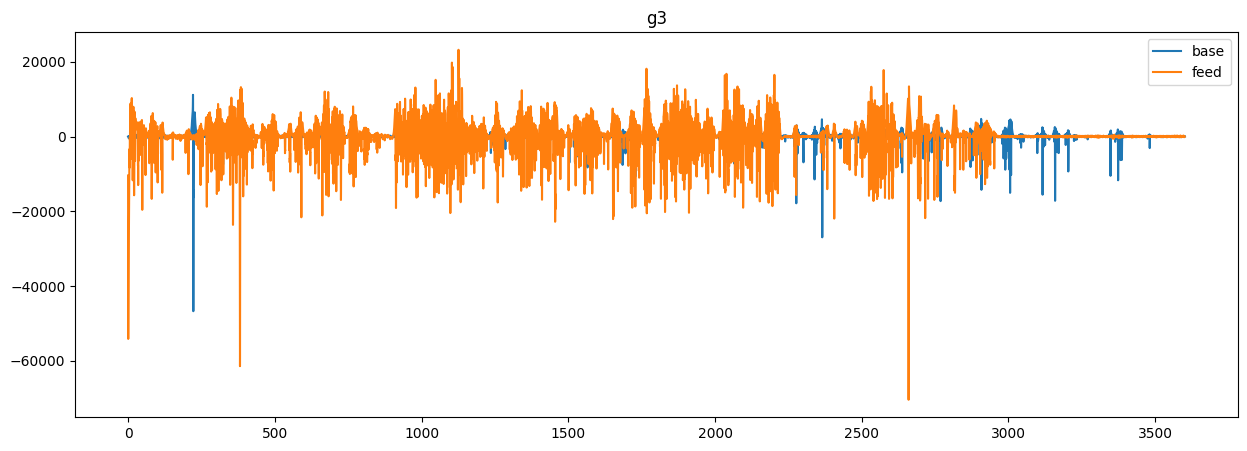

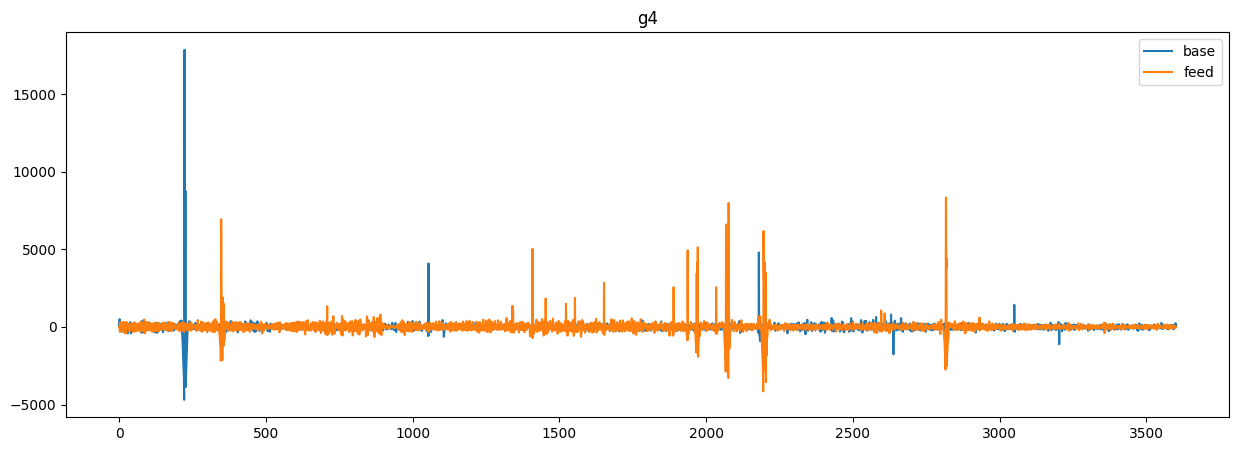

In [10]:
if filter_type == 'bandpass':
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.bandpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           lowcut=lo_cutoff, highcut=hi_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If high pass

In [11]:
if (filter_type == 'butter_high_low') or (filter_type == 'butter_high_savgol_low') or (filter_type == 'butter_high_only'):
    
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.highpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, cutoff_freq=lo_cutoff)
        exec(x + ' = df_x')

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## If low pass

In [12]:
if filter_type == 'butter_high_low':
        
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            df_x[y] = Preprocessing.lowpass_butter_filter(arr=df_x[y], order=2, sample_freq=new_sample_freq, 
                                                           cutoff_freq=hi_cutoff)
        exec(x + ' = df_x')
        
    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

if filter_type == 'butter_high_savgol_low':
            
    for x in df_name_lst:
        df_x = locals()[x]
        for y in chan_to_keep[1:]:
            arr = Preprocessing.savitzky_golay_filter(arr=df_x[y].values, win_len=sg_len, order=sg_order)
            df_x[y] = pd.Series(arr)
        exec(x + ' = df_x')

    for x in col_names[1:]:
        plt.figure(figsize=(15,5))
        plt.title(x)
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [13]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Artifact removal > 2 mV

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 2.42 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 12.66 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 40.94 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.89 %


time          g1          g2           g3        g4
0          0.000 -284.232601  251.743831 -1314.253913 -7.345904
1          0.005 -285.035244  252.220650 -1314.253913 -7.299996
2          0.010 -285.798068  252.697527 -1314.253913 -7.243152
3          0.015 -286.519489  253.174316 -1314.253913 -7.175190
4          0.020 -287.197930  253.650933 -1314.253913 -7.095952
...          ...         ...         ...          ...       ...
720130  3600.650   -0.122123    0.376794    -0.406842 -0.156494
720131  3600.655   -0.105173    0.323115    -0.347763 -0.133495
720132  3600.660   -0.089734    0.274527    -0.294526 -0.112815
720133  3600.665   -0.075764    0.230837    -0.246867 -0.094343
720134  3600.670   -0.063220    0.191839    -0.204512 -0.077968

[720135 rows x 5 columns]

w/ Linear interpolation
w/ backfill on front end
Percentage removed: 2.24 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 4.57 %
w/ Linear interpolation
w/ backfill on front end
Percentage removed: 3.14 %


w/ Linear interpolation
w/ backfill on front end
Percentage removed: 0.36 %


time         g1          g2         g3         g4
0          0.000 -58.513646  332.720089  11.952686  21.580533
1          0.005 -58.605959  332.371839  10.538933  22.564785
2          0.010 -58.699235  332.009330   9.129715  23.562233
3          0.015 -58.793508  331.632548   7.725683  24.572890
4          0.020 -58.888809  331.241487   6.327488  25.596764
...          ...        ...         ...        ...        ...
720206  3601.030  -0.695732   -0.249925   0.340504   1.393825
720207  3601.035  -0.595189   -0.215826   0.302898   1.192597
720208  3601.040  -0.504384   -0.184673   0.266721   1.010888
720209  3601.045  -0.422946   -0.156406   0.232241   0.847909
720210  3601.050  -0.350477   -0.130949   0.199702   0.702830

[720211 rows x 5 columns]

cond chan  removed_pct
0  df_feed   g1         2.42
1  df_feed   g2        12.66
2  df_feed   g3        40.94
3  df_feed   g4         0.89
4  df_base   g1         2.24
5  df_base   g2         4.57
6  df_base   g3         3.14
7  df_base   g4         0.36

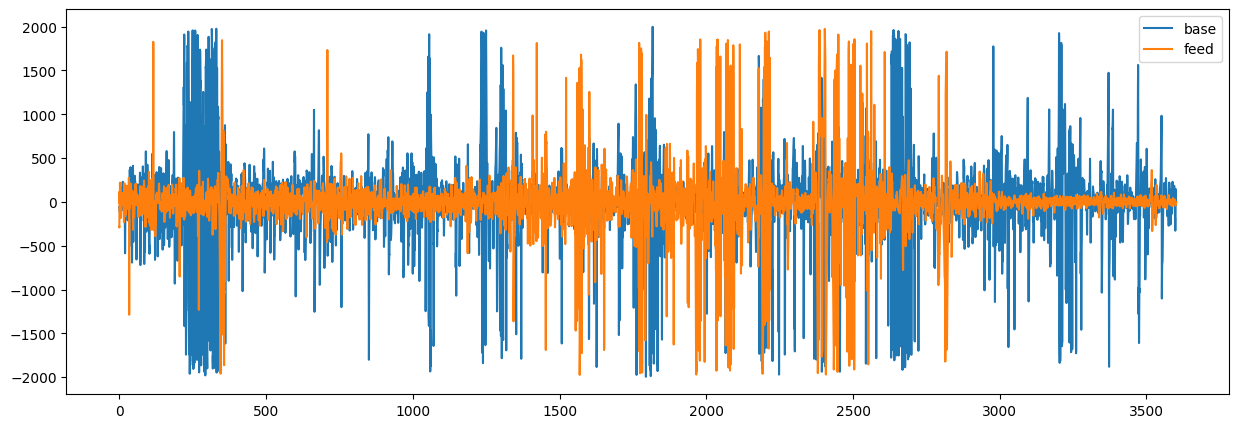

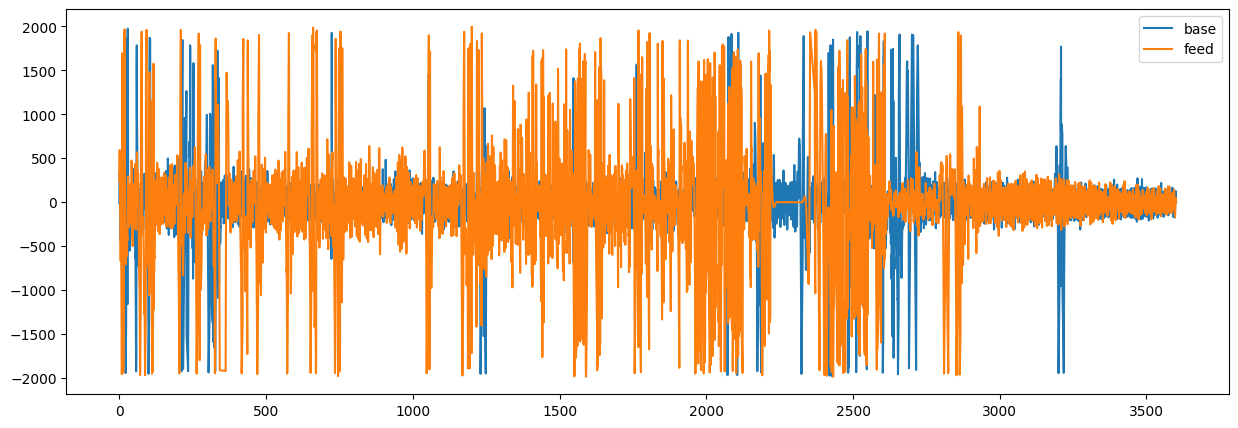

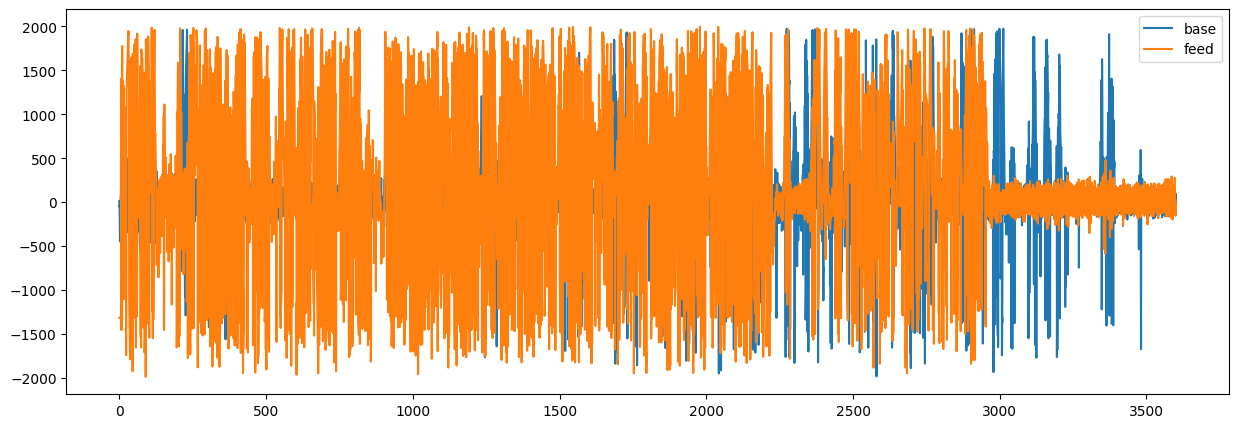

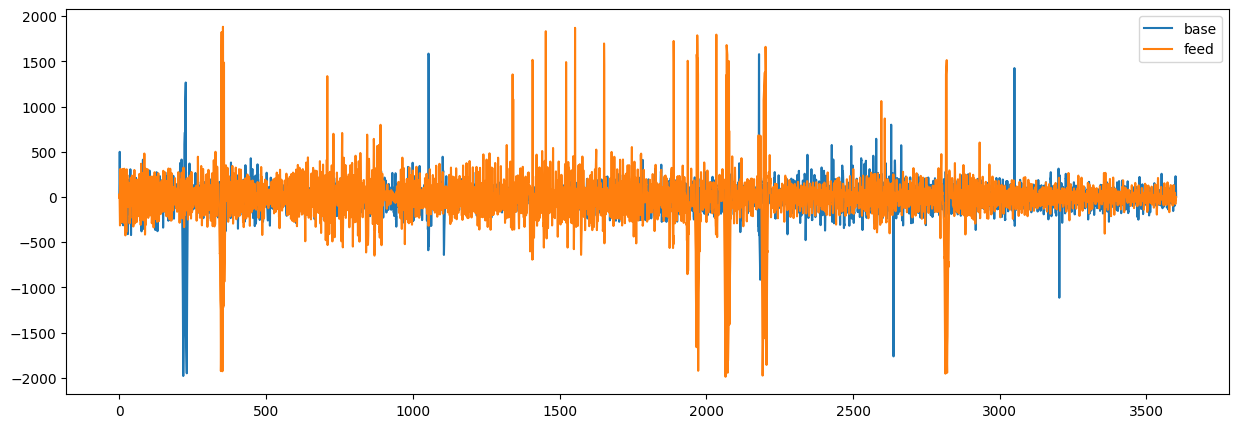

In [14]:
if use_artifact_removal:
    
    df_artifact_remove = pd.DataFrame()
    
    removed_pct_lst = []
    cond_lst = []
    chan_lst = []

    for x in df_name_lst:
 
        df_x = locals()[x]
        
        for y in chan_to_keep[1:]:
            
            # apply filter
            df_x[y], removed_pct = Preprocessing.artifacts_removal(arr=df_x[y], thres=2000, 
                                                                   pts_pre=pre_post_pts, 
                                                                   pts_post=pre_post_pts, 
                                                                   interpolate=True,
                                                                   fill_frontend=fill_frontend)
            removed_pct_lst.append(removed_pct)
            cond_lst.append(x)
            chan_lst.append(y)
        print(df_x)   
        exec(x + ' = df_x')
 
    df_artifact_remove['cond'] = cond_lst
    df_artifact_remove['chan'] = chan_lst
    df_artifact_remove['removed_pct'] = removed_pct_lst
    
    print(df_artifact_remove)

    for x in chan_to_keep[1:]:
        plt.figure(figsize=(15,5))
        plt.plot(df_base['time'], df_base[x], label='base')
        plt.plot(df_feed['time'], df_feed[x], label='feed')
        plt.legend(loc='upper right')

## Determine percentage missing values

In [15]:
for x in df_name_lst:
    print(x)
    df1 = locals()[x]
    nans_lst, zeros_lst = Preprocessing.percent_nans_zeros_tolist(df=df1)
    print('nans')
    print(nans_lst[1:])
    print('zeros')
    print(zeros_lst[1:])
    print('#####################')
    print()

df_feed

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

df_base

nans

[0.0, 0.0, 0.0, 0.0]

zeros

[0.0, 0.0, 0.0, 0.0]

#####################

# Plots: power spectral density (from 3 to 15 cpm)

df_feed

Total power = 120960156.24603647 Dom freq = 0.10331381850094981

Bradygastric power = 51832212.48308644 Dom freq = 0.10331381850094981

normygastric power = 38992550.82026209 Dom freq = 0.14108446182387768

tachygastric power = 30135392.94268793 Dom freq = 0.19774042680826953

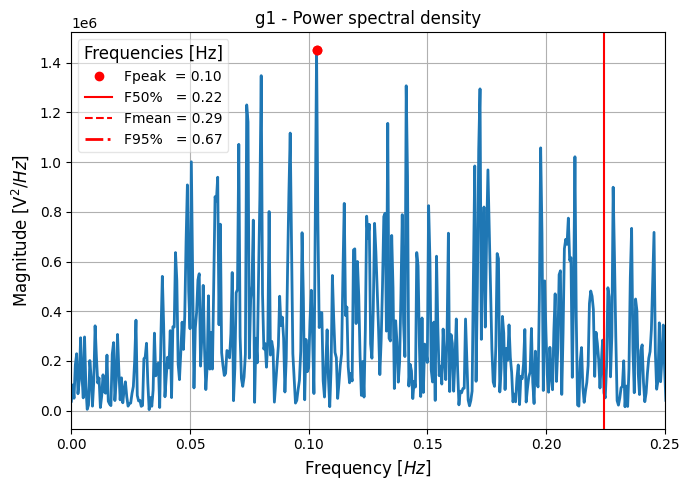

Total power = 472159737.6346079 Dom freq = 0.17385604941288865

Bradygastric power = 232508679.3938185 Dom freq = 0.062210471355410635

normygastric power = 155030411.95955405 Dom freq = 0.17385604941288865

tachygastric power = 84620646.28123532 Dom freq = 0.20884943955030713

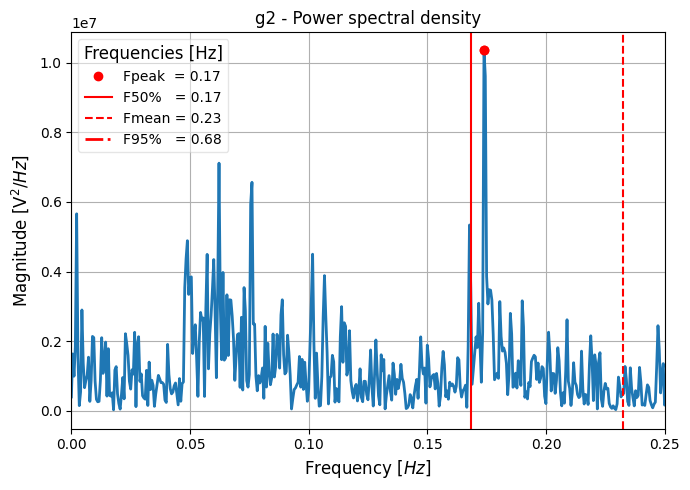

Total power = 976907346.8907503 Dom freq = 0.09164935512181031

Bradygastric power = 490528437.8578037 Dom freq = 0.09164935512181031

normygastric power = 269793419.51960826 Dom freq = 0.13664085672706264

tachygastric power = 216585489.51333824 Dom freq = 0.19163046980014883

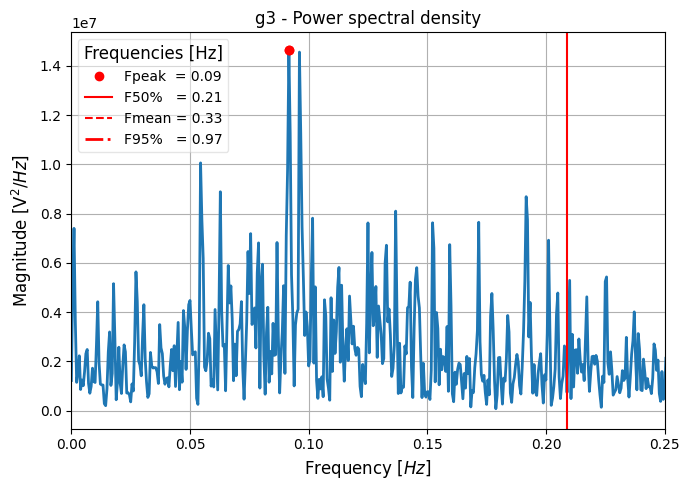

Total power = 94898171.63331339 Dom freq = 0.17385604941288865

Bradygastric power = 47243136.37843071 Dom freq = 0.06943132963773509

normygastric power = 35731976.47554765 Dom freq = 0.17385604941288865

tachygastric power = 11923058.779335048 Dom freq = 0.20718308763900148

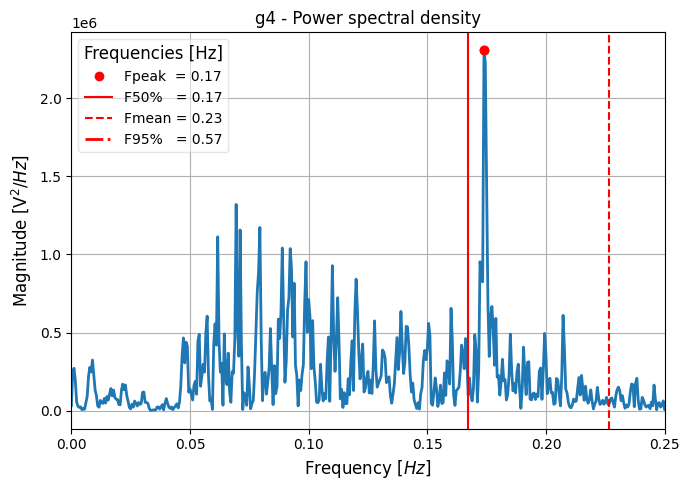

df_base

Total power = 194887275.95437926 Dom freq = 0.10274752434005543

Bradygastric power = 125876854.54477 Dom freq = 0.10274752434005543

normygastric power = 43460953.74134242 Dom freq = 0.182168583694801

tachygastric power = 25549467.668266866 Dom freq = 0.1916102480936169

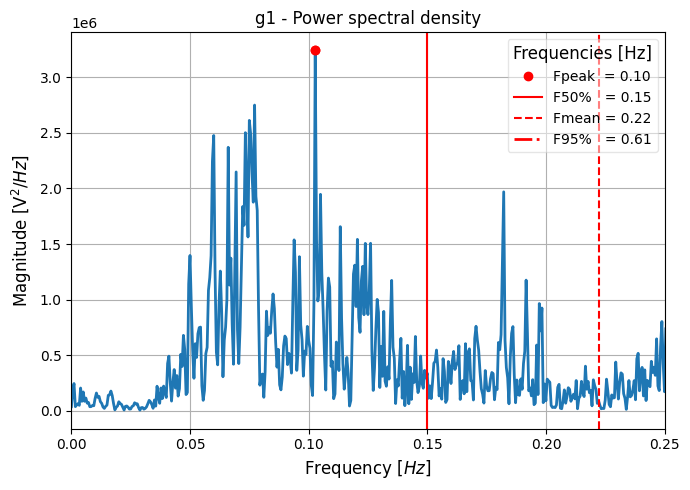

Total power = 90590410.54743382 Dom freq = 0.18327936774172052

Bradygastric power = 49020812.62321744 Dom freq = 0.05942694651019423

normygastric power = 32744050.741890177 Dom freq = 0.18327936774172052

tachygastric power = 8825547.1823262 Dom freq = 0.19327642416399618

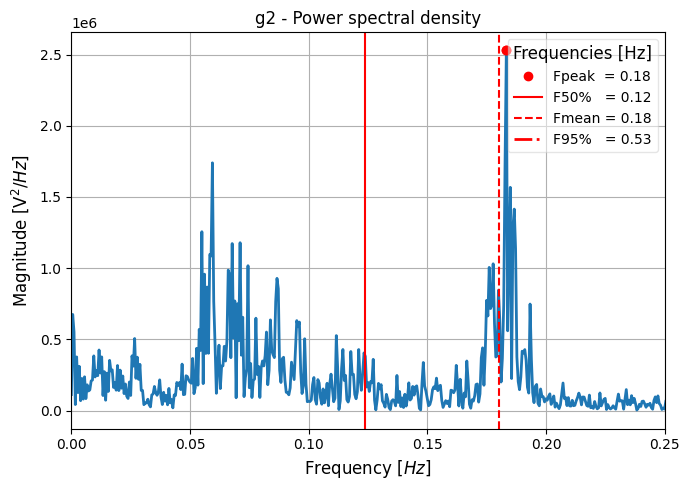

Total power = 77009933.52617419 Dom freq = 0.18550093583555954

Bradygastric power = 21673629.76524964 Dom freq = 0.08497497958934315

normygastric power = 33663694.57131852 Dom freq = 0.18550093583555954

tachygastric power = 21672609.18960604 Dom freq = 0.19383181618745593

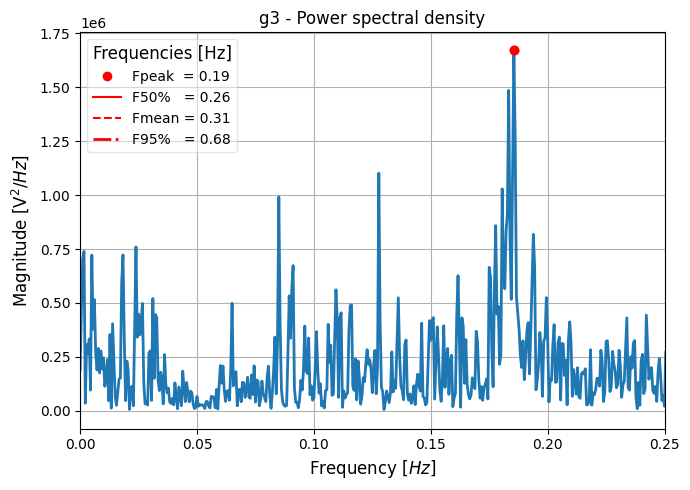

Total power = 19748908.86911072 Dom freq = 0.18327936774172052

Bradygastric power = 7707374.307032083 Dom freq = 0.06609165079171134

normygastric power = 8210859.120202979 Dom freq = 0.18327936774172052

tachygastric power = 3830675.4418756575 Dom freq = 0.19327642416399618

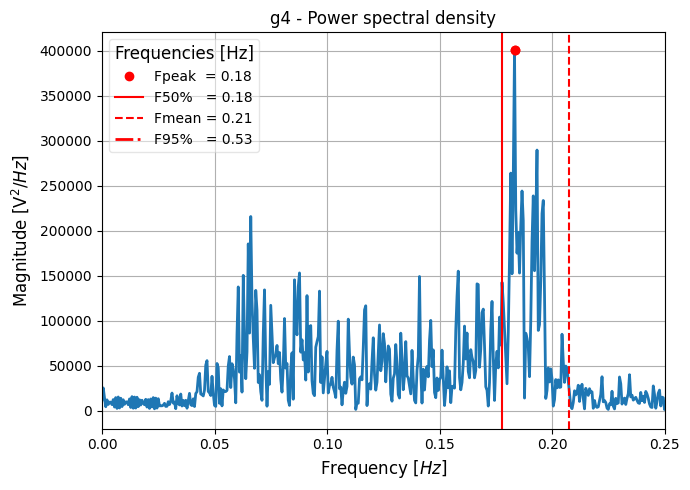

cond chan     tot_power    brad_power    norm_power    tach_power  \
0  df_feed   g1  1.209602e+08  5.183221e+07  3.899255e+07  3.013539e+07   
0  df_feed   g2  4.721597e+08  2.325087e+08  1.550304e+08  8.462065e+07   
0  df_feed   g3  9.769073e+08  4.905284e+08  2.697934e+08  2.165855e+08   
0  df_feed   g4  9.489817e+07  4.724314e+07  3.573198e+07  1.192306e+07   
0  df_base   g1  1.948873e+08  1.258769e+08  4.346095e+07  2.554947e+07   
0  df_base   g2  9.059041e+07  4.902081e+07  3.274405e+07  8.825547e+06   
0  df_base   g3  7.700993e+07  2.167363e+07  3.366369e+07  2.167261e+07   
0  df_base   g4  1.974891e+07  7.707374e+06  8.210859e+06  3.830675e+06   

   brad_domf  norm_domf  tach_domf  
0     0.1033     0.1411     0.1977  
0     0.0622     0.1739     0.2088  
0     0.0916     0.1366     0.1916  
0     0.0694     0.1739     0.2072  
0     0.1027     0.1822     0.1916  
0     0.0594     0.1833     0.1933  
0     0.0850     0.1855     0.1938  
0     0.0661     0.1833     0.1933

#########################################################

In [16]:
df_summary = pd.DataFrame()

for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        df_final = Plotting.psd(df_x[y], fs=new_sample_freq, xlim=[0,0.25], units='V', title=y, 
                                tot_pwr_lst=[0.05, 0.25], brad_pwr_lst=[0.05, 0.127], norm_pwr_lst=[0.127, 0.19], tach_pwr_lst=[0.19, 0.25])
        df_final['cond'] = x
        df_final['chan'] = y
        df_summary = pd.concat([df_summary, df_final])
    exec(x + '_summary = df_summary')

# change the order of columns and drop a column
df_summary = df_summary[['cond', 'chan', 'tot_power', 'brad_power', 'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf']]
    
print(df_summary)

print('#########################################################')
print()

# Plot spectrograms

df_feed

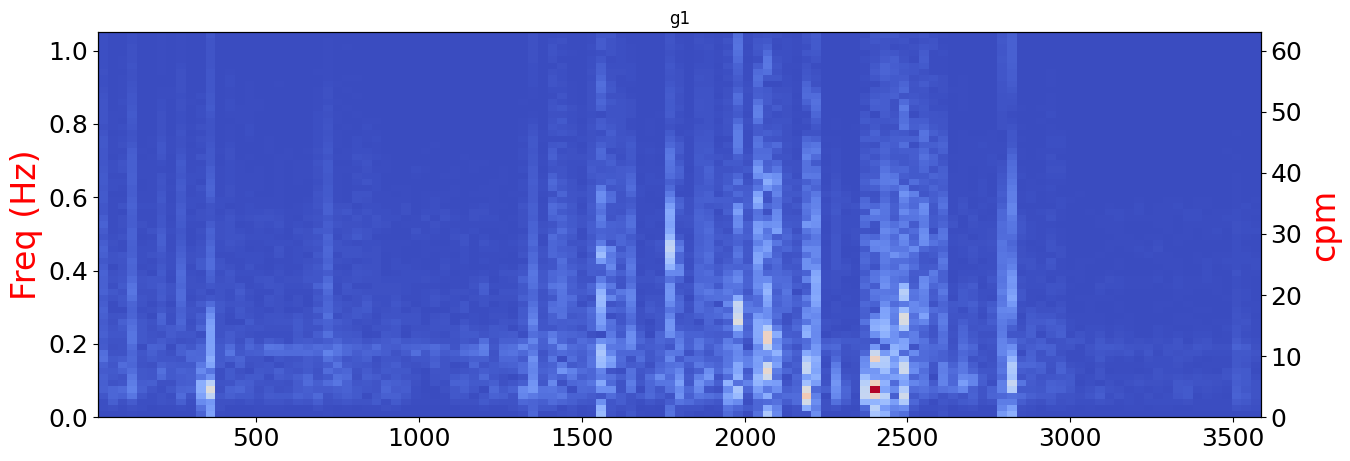

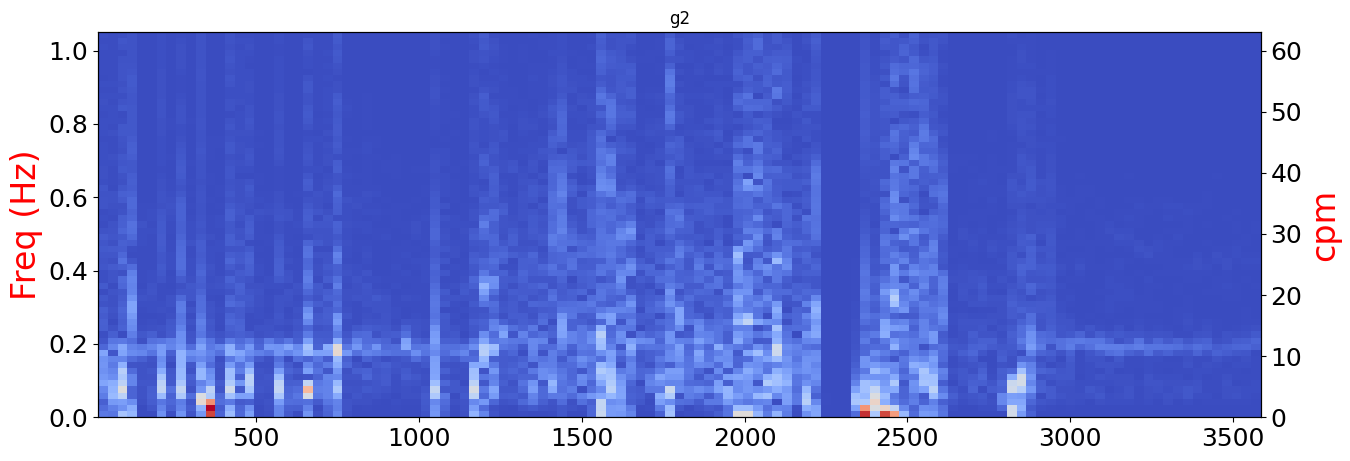

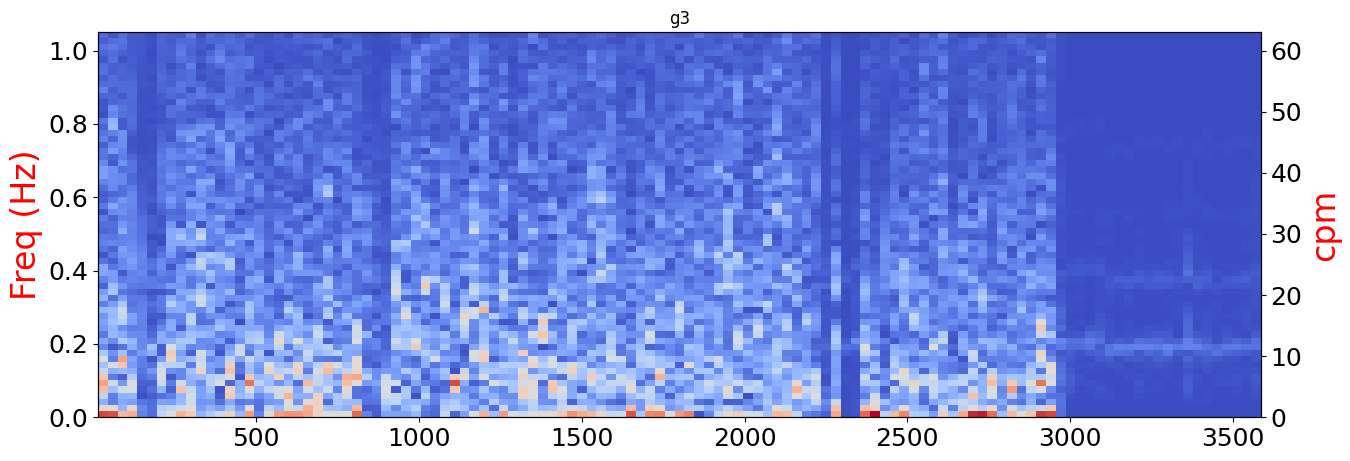

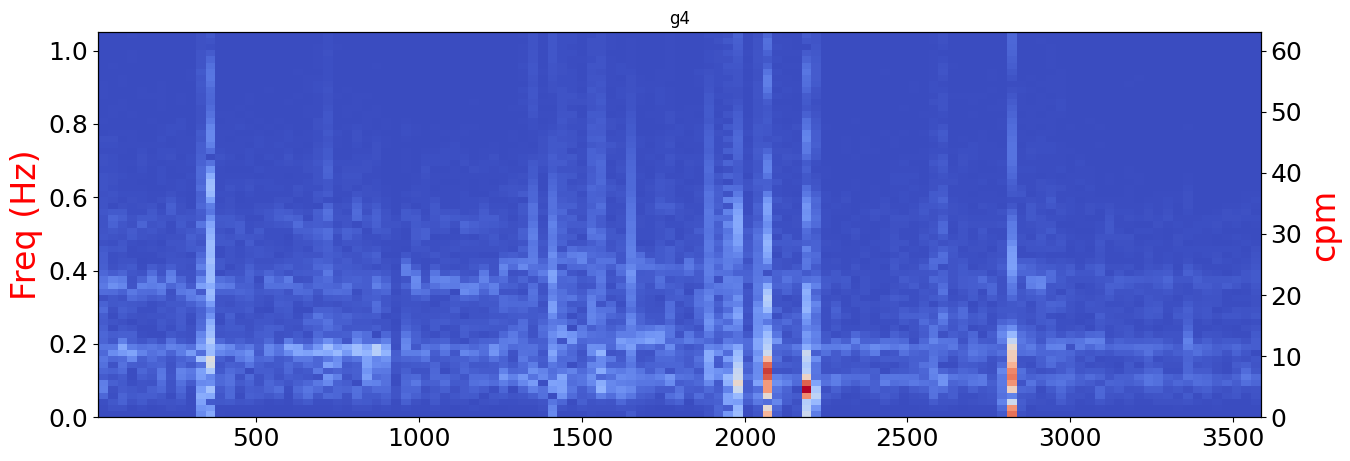

#########################################################

df_base

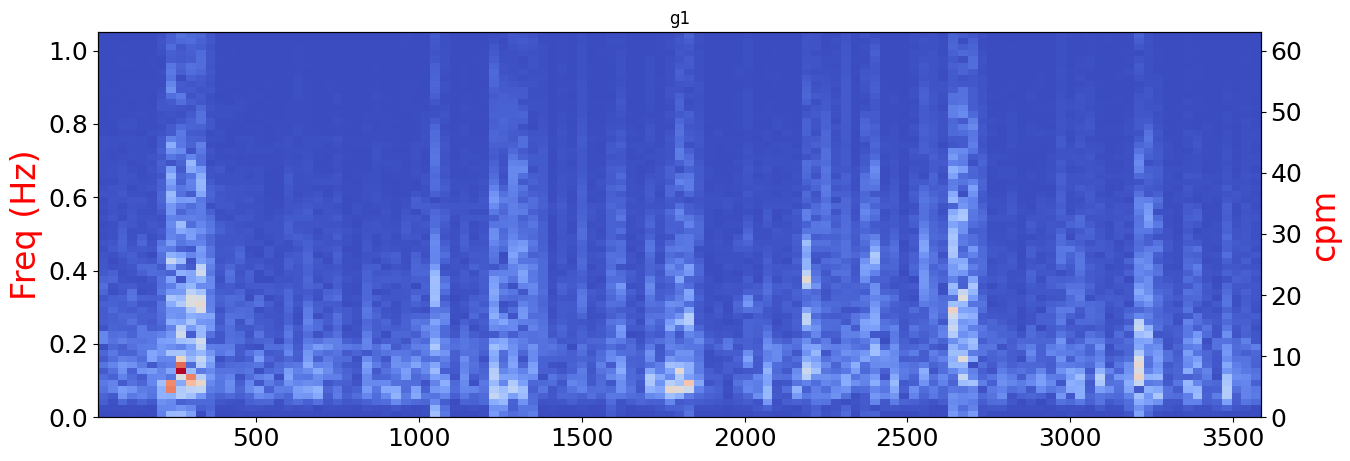

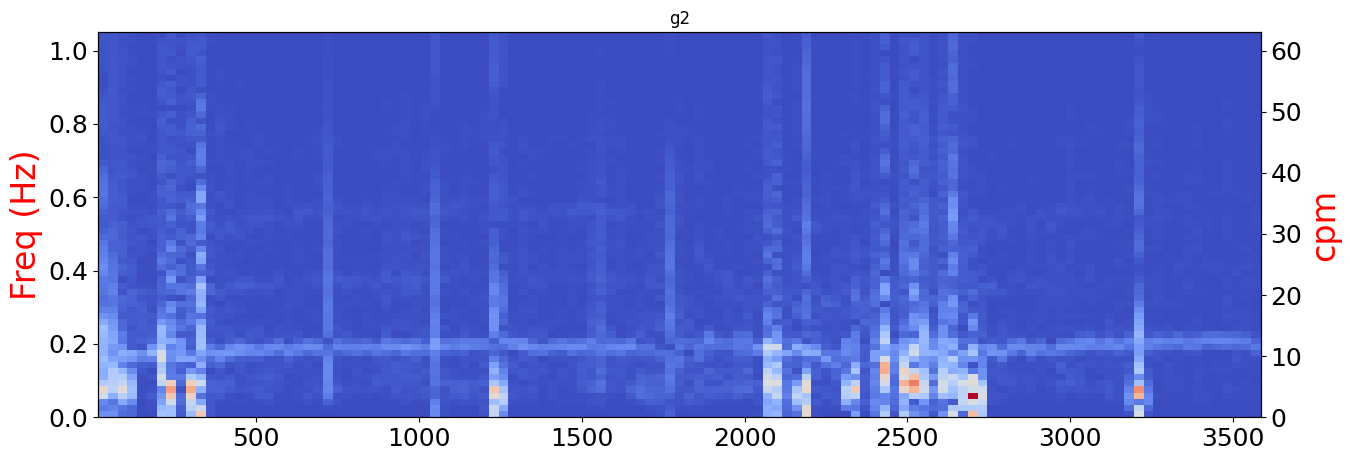

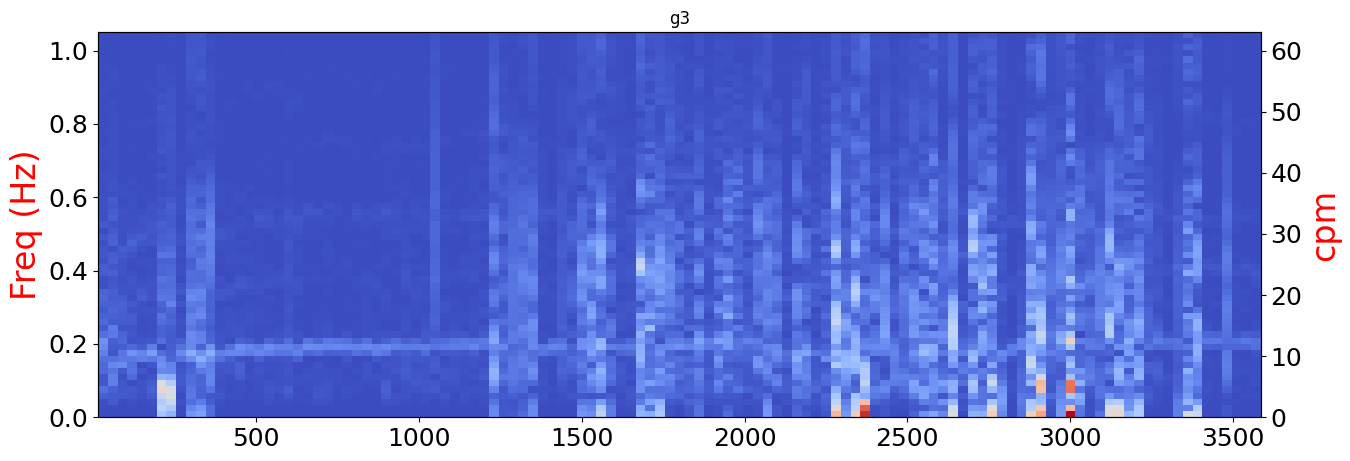

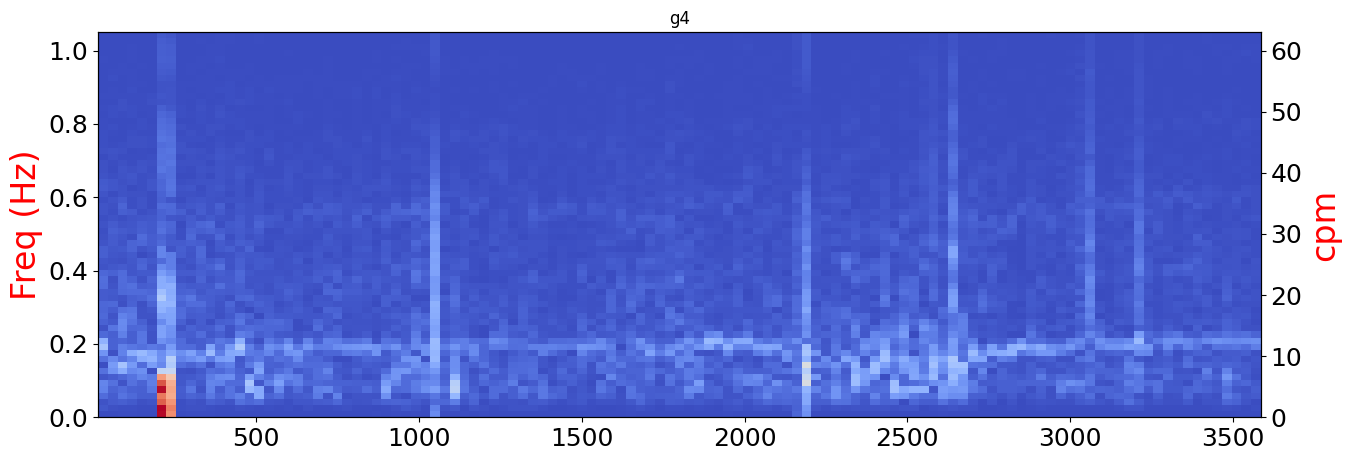

#########################################################

In [17]:
for x in df_name_lst:
    
    print(x)

    df_x = locals()[x]
    
    for y in chan_to_keep[1:]:
        Plotting.spect(arr=df_x[y], sample_freq=new_sample_freq, y_max_freq=1.5*hi_cutoff, plot_title=y)
        
    print('#########################################################')
    print()

# make summary table

In [18]:
# use deep = true to make sure that original will not be changed when modifying copy
df_copy = df_summary.copy(deep=True)

# add columns
df_copy['packet_remove_pct'] = df_packet_drop['removed_pct'].values
df_copy['art_remove_pct'] = df_artifact_remove['removed_pct'].values
df_copy['animal'] = pd.Series(animal, index=df_copy.index)
df_copy['new_sample_freq'] = pd.Series(new_sample_freq, index=df_copy.index)
df_copy['filter_type'] = pd.Series(filter_type, index=df_copy.index)
df_copy['lo_cutoff'] = pd.Series(lo_cutoff, index=df_copy.index)
df_copy['hi_cutoff'] = pd.Series(hi_cutoff, index=df_copy.index)
df_copy['remove_drop_packs'] = pd.Series(use_dropped_packet_removal, index=df_copy.index)
df_copy['remove_artifact'] = pd.Series(use_artifact_removal, index=df_copy.index)

# reorder columns
df_copy = df_copy[['animal', 'cond', 'chan', 'new_sample_freq', 'filter_type', 'lo_cutoff', 'hi_cutoff', 
                   'remove_drop_packs', 'remove_artifact', 'tot_power', 'brad_power', 
                   'norm_power', 'tach_power', 'brad_domf', 'norm_domf', 'tach_domf', 'packet_remove_pct', 'art_remove_pct']]

# replace characters
df_copy['cond'] = df_copy.cond.str.replace('df_', '')

print(df_copy)

# Write to file
results_file = 'summary.csv'

# make a results file
if not os.path.exists(results_file):
    os.mknod(results_file)
    df_copy.to_csv(results_file)  
elif os.path.exists(results_file):
    df_copy.to_csv(results_file, mode='a', header=False)

animal  cond chan  new_sample_freq filter_type  lo_cutoff  hi_cutoff  \
0  87-21  feed   g1              200    bandpass       0.05        0.7   
0  87-21  feed   g2              200    bandpass       0.05        0.7   
0  87-21  feed   g3              200    bandpass       0.05        0.7   
0  87-21  feed   g4              200    bandpass       0.05        0.7   
0  87-21  base   g1              200    bandpass       0.05        0.7   
0  87-21  base   g2              200    bandpass       0.05        0.7   
0  87-21  base   g3              200    bandpass       0.05        0.7   
0  87-21  base   g4              200    bandpass       0.05        0.7   

   remove_drop_packs  remove_artifact     tot_power    brad_power  \
0               True             True  1.209602e+08  5.183221e+07   
0               True             True  4.721597e+08  2.325087e+08   
0               True             True  9.769073e+08  4.905284e+08   
0               True             True  9.489817e+07  4.724314e+07   
0               True             True  1.948873e+08  1.258769e+08   
0               True             True  9.059041e+07  4.902081e+07   
0               True             True  7.700993e+07  2.167363e+07   
0               True             True  1.974891e+07  7.707374e+06   

     norm_power    tach_power  brad_domf  norm_domf  tach_domf  \
0  3.899255e+07  3.013539e+07     0.1033     0.1411     0.1977   
0  1.550304e+08  8.462065e+07     0.0622     0.1739     0.2088   
0  2.697934e+08  2.165855e+08     0.0916     0.1366     0.1916   
0  3.573198e+07  1.192306e+07     0.0694     0.1739     0.2072   
0  4.346095e+07  2.554947e+07     0.1027     0.1822     0.1916   
0  3.274405e+07  8.825547e+06     0.0594     0.1833     0.1933   
0  3.366369e+07  2.167261e+07     0.0850     0.1855     0.1938   
0  8.210859e+06  3.830675e+06     0.0661     0.1833     0.1933   

   packet_remove_pct  art_remove_pct  
0               2.58            2.42  
0               6.35           12.66  
0               3.94           40.94  
0               0.29            0.89  
0               2.77            2.24  
0               0.72            4.57  
0               0.17            3.14  
0               0.06            0.36

# make filtered files

In [19]:
if not os.path.exists('final_filt_data'):
    os.mkdir('final_filt_data')
    
for x in df_name_lst:

    df_x = locals()[x]    
    
    # make csv
    df_x.to_csv('final_filt_data/' + animal + '_' + x + '.csv', index=False)
    
    # make pickle
    f = open('final_filt_data/' + animal + '_' + x + '.pckl', 'wb')
    pickle.dump(df_x, f)
    f.close()